# Completion Rate per client - Segmentación por edad

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")

# --------------------------------------------------
# PASO 2: Definir si el cliente completó el proceso (llegó a 'confirm')
# --------------------------------------------------
# Para cada registro, se asigna 'completed' = True si process_step == "confirm", False en caso contrario.
df["completed"] = df["process_step"] == "confirm"

# --------------------------------------------------
# PASO 3: Agrupar a nivel de cliente (client_id) y variation
# --------------------------------------------------
# Cada cliente se agrupa para que, si completó al menos una sesión, se marque como True.
# También se conserva la edad del cliente (se usa "first" ya que no debería variar dentro de un mismo cliente)
df_clients = (
    df.groupby(["variation", "client_id"], as_index=False)
      .agg({"completed": "max", "clnt_age": "first"})
)

# (Opcional) Filtrar para excluir registros Unknown en variation, si se desea
df_clients = df_clients[df_clients["variation"].isin(["Control", "Test"])].copy()

# --------------------------------------------------
# PASO 4: Crear categorías de edad en el DataFrame de clientes
# --------------------------------------------------
bins = [0, 35, 55, 120]          # Definimos intervalos de edad
labels = ["<35", "35-55", ">55"]  # Etiquetas para cada intervalo
df_clients["age_bin"] = pd.cut(df_clients["clnt_age"], bins=bins, labels=labels, include_lowest=True)

## Gráfico

In [6]:
# --------------------------------------------------
# PASO 5: Calcular la Completion Rate (CR) por rango de edad y grupo
# --------------------------------------------------
df_cr_by_age = (
    df_clients.groupby(["age_bin", "variation"],  observed=False, as_index=False)["completed"]
    .mean()  # La media equivale a la tasa de finalización en cada combinación
)

# Generate CSV file with the final DataFrame
df_cr_by_age.to_csv("../../data/processed/1_CR_tableau.csv", index=False)
print("Archivo guardado exitosamente!")

Archivo guardado exitosamente!


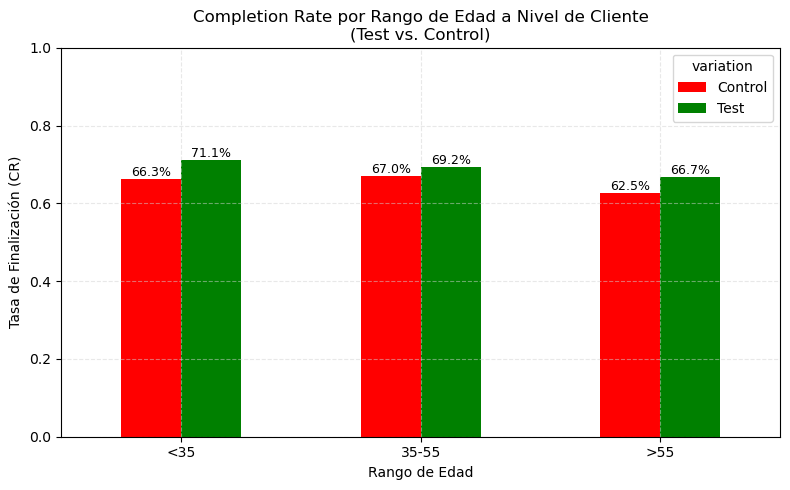

In [ ]:


# --------------------------------------------------
# PASO 6: Convertir a tabla dinámica para facilitar el gráfico
# --------------------------------------------------
df_pivot = df_cr_by_age.pivot(index="age_bin", columns="variation", values="completed")

# --------------------------------------------------
# PASO 7: Definir colores
# --------------------------------------------------
color_map = {"Control": "red", "Test": "green", "Unknown": "gray"}
colors = [color_map.get(col, "gray") for col in df_pivot.columns]

# --------------------------------------------------
# PASO 8: Graficar
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

df_pivot.plot(
    kind="bar",
    ax=ax,
    color=colors,
    legend=True  # Mostramos leyenda
)

ax.set_title("Completion Rate por Rango de Edad a Nivel de Cliente\n(Test vs. Control)")
ax.set_xlabel("Rango de Edad")
ax.set_ylabel("Tasa de Finalización (CR)")
ax.set_ylim(0, 1)

# --- A) Añadir rejilla (grid) con líneas discontinuas grises ---
ax.grid(True, which='major', axis='both', color='lightgray', linestyle='--', alpha=0.5)

# --- B) Añadir etiquetas de porcentaje sobre cada barra ---
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(
            f"{height:.1%}",
            (p.get_x() + p.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/cr_age_client.jpg", dpi=300, bbox_inches='tight')
plt.show()